# Coursework 2: Image Classification

In this coursework, we are going to develop a neural network model for for image classification.

What to do?

* The coursework includes both coding questions and written questions. Please read both the text and code comment in this notebook to get an idea what you are supposed to implement.

* First, run `jupyter-lab` or `jupyter-notebook` in the terminal to start the Jupyter notebook.

* Then, complete and run the code to get the results.

* Finally, please export (File | Export Notebook As...) or print (using the print function of your browser) the notebook as a pdf file, which contains your code, results and answers, and upload the pdf file onto Cate.

Dependencies:

* If you work on a college computer in the Computer Lab, where Ubuntu 18.04 is installed by default, you can use the following virtual environment for your work, where required Python packages are already installed.

`source /vol/bitbucket/wbai/virt/computer_vision_2020/bin/activate`

When you no longer need the virtual environment, you can exit it by running `deactivate`.

* If you work on your own laptop using either Anaconda or plain Python, you can install new packages (such as numpy, imageio etc) running `conda install [package_name]` or `pip3 install [package_name]` in the terminal.

In [0]:
# Import libraries (provided)
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import image
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import seaborn as sn
import pandas as pd
from PIL import Image
import cv2

# 1. Load and visualise data. (25 marks)

Throughout this coursework. you will be working with the Fashion-MNIST dataset. If you are interested, you may find information about the dataset in this paper.

[1] Han Xiao, Kashif Rasul, Roland Vollgraf. Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The dataset is prepared in a similar way to MNIST. It is split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [2]:
# Load data (provided)
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True,transform=transforms.ToTensor())
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False,transform=transforms.ToTensor())
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


### 1.1 Display the dimension of the training and test sets. (5 marks)

In [3]:
print(f"the dimension of the training set is: {train_set.data.shape}")
print(class_name)
print(train_set)
print(train_label)

print(f"the dimension of the test set is: {test_set.data.shape}")

the dimension of the training set is: torch.Size([60000, 28, 28])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()
[9 0 0 ... 3 0 5]
the dimension of the test set is: torch.Size([10000, 28, 28])


### 1.2 Visualise sample images for each of the 10 classes. (10 marks)

Please plot 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

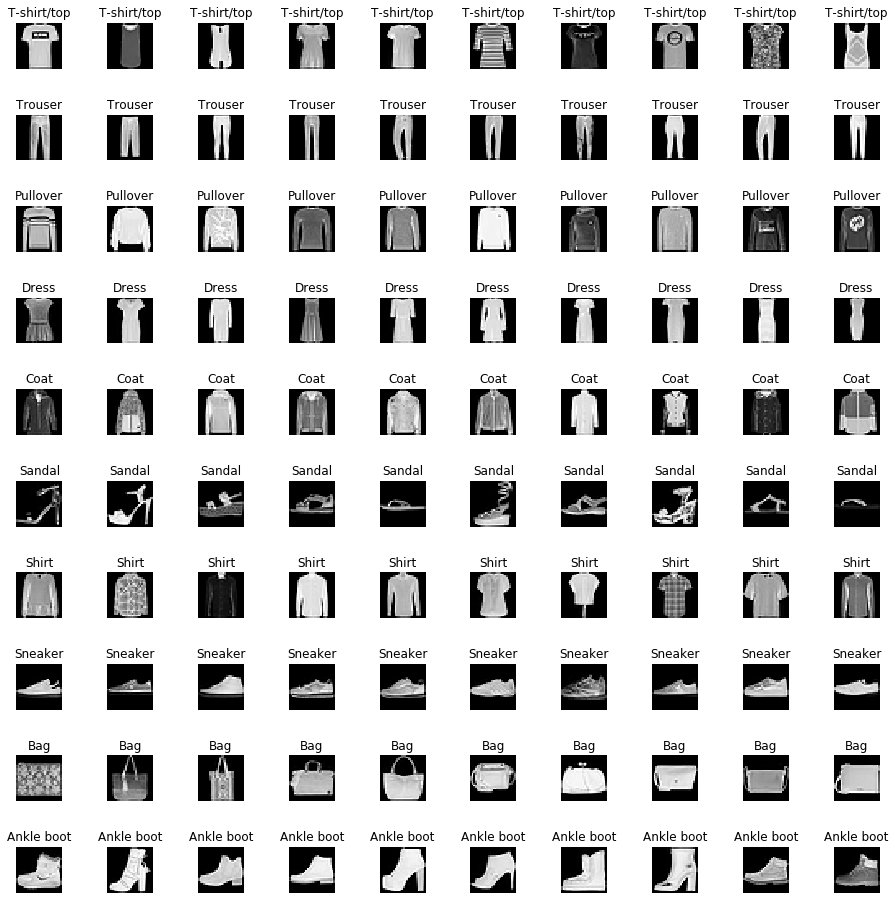

In [4]:
N=10
fig, axes = plt.subplots(N,N,figsize=(16,16))

for row in range(N):
  col=0
  for i in range(200):
    if col==10:
      break
    elif (train_label[i]==row):
        axes[row,col].axis('off')
        axes[row,col].set_title(class_name[row])
        axes[row,col].imshow(train_image[i],cmap='gray')
        fig.subplots_adjust(hspace=1) 
        col+=1

### 1.3 Display the number of training samples for each class. (5 marks)

In [5]:
label, counts = np.unique(train_label, return_counts=True)
old = dict(zip(label, counts))

for i in range(10):
    new = dict(zip(class_name, list(old.values())))

print(new)


{'T-shirt/top': 6000, 'Trouser': 6000, 'Pullover': 6000, 'Dress': 6000, 'Coat': 6000, 'Sandal': 6000, 'Shirt': 6000, 'Sneaker': 6000, 'Bag': 6000, 'Ankle boot': 6000}


### 1.4 Discussion. (5 marks)
Is the dataset balanced? What would happen for the image classification task if the dataset is not balanced? 

## 2. Image classification. (60 marks)

### 2.1 Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. (15 marks)

You can use a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](https://github.com/lengwe/Computer_Vision_2020/blob/master/coursework_2/lenet.png?raw=1)

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        #convolution and subsampling layers
        self.conv1 = nn.Conv2d(1,6,kernel_size=5,stride=1,padding=0)
        self.conv2 = nn.Conv2d(6,16,kernel_size=5,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)

        #fully connection
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 2.2 Define the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc. (5 marks)

In [0]:
batch = 128
learning_rate = 0.01
iteration = 30
#Setting GPU device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### 2.3 Start model training. (20 marks)

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent. Please also evaluate how long it takes for training.

Epoch [1/30], Loss: 0.491831 Train Accuracy: 77.08%
Epoch [2/30], Loss: 0.564739 Train Accuracy: 78.12%
Epoch [3/30], Loss: 0.367935 Train Accuracy: 82.29%
Epoch [4/30], Loss: 0.589351 Train Accuracy: 78.12%
Epoch [5/30], Loss: 0.262166 Train Accuracy: 91.67%
Epoch [6/30], Loss: 0.417121 Train Accuracy: 90.62%
Epoch [7/30], Loss: 0.310603 Train Accuracy: 87.50%
Epoch [8/30], Loss: 0.401425 Train Accuracy: 83.33%
Epoch [9/30], Loss: 0.295000 Train Accuracy: 88.54%
Epoch [10/30], Loss: 0.370361 Train Accuracy: 87.50%
Epoch [11/30], Loss: 0.175514 Train Accuracy: 94.79%
Epoch [12/30], Loss: 0.276879 Train Accuracy: 91.67%
Epoch [13/30], Loss: 0.261371 Train Accuracy: 88.54%
Epoch [14/30], Loss: 0.310103 Train Accuracy: 86.46%
Epoch [15/30], Loss: 0.250752 Train Accuracy: 91.67%
Epoch [16/30], Loss: 0.120201 Train Accuracy: 94.79%
Epoch [17/30], Loss: 0.202874 Train Accuracy: 93.75%
Epoch [18/30], Loss: 0.365485 Train Accuracy: 86.46%
Epoch [19/30], Loss: 0.239434 Train Accuracy: 88.54%
Ep

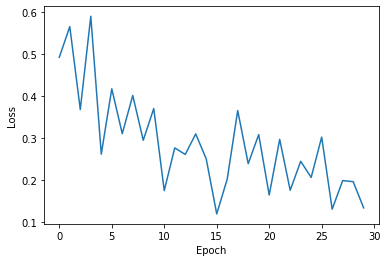

Finished Training within 4 min 10 sec


In [8]:
time_start = time.process_time()
loss_epo = []
acc_list = []
for epoch in range(iteration):
    train_loader  = torch.utils.data.DataLoader(train_set,batch_size=batch, shuffle=True)
    for i,(inputs,labels) in enumerate(train_loader,0):
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output,labels)
        loss.backward() 
        optimizer.step()

        #Evaluate accuracy
        total = labels.size(0)
        _,predicted = torch.max(output.data,1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
    loss_epo.append(loss.item())

    print('Epoch [{}/{}], Loss: {:.6f} Train Accuracy: {:.2f}%'.format(epoch + 1, iteration, loss.item(), (correct/total)*100))

plt.plot(loss_epo)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#Execution time 
time_elapse = time.process_time()-time_start
minutes, seconds = divmod(int(time_elapse), 60)
print(f'Finished Training within {minutes} min {seconds} sec')

### 2.4 Deploy the trained model onto the test set. (10 marks)
Please also evaluate how long it takes for testing.

In [13]:
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch,shuffle=True)
model.eval()

with torch.no_grad():
  time_start = time.process_time()
  for inputs, labels in test_loader:
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)

time_elapse = time.process_time()-time_start
minutes, seconds = divmod(float(time_elapse), 60)
print(f'Finished testing within {minutes} min {seconds} sec')

Finished testing within 0.0 min 1.2737464619999628 sec


### 2.5 Evaluate the classification accuracy on the test set. (5 marks)

In [14]:
model.eval()
p=torch.zeros(0,dtype=torch.long, device='cpu')
l=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
  correct = 0
  total = 0
  for inputs, labels in test_loader:
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    p=torch.cat([p,predicted.view(-1).cpu()])
    l=torch.cat([l,labels.view(-1).cpu()])
print('The classification accuracy on the test set is: {:.3f} %'.format((correct / total) * 100))

The classification accuracy on the test set is: 89.190 %


### 2.6 Print out and visualise the confusion matrix. (5 marks)
You can use relevant functions in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

[[816   1  16  22   4   0 128   0  13   0]
 [  1 977   0  14   4   1   1   0   2   0]
 [ 12   2 816   8  97   0  61   0   4   0]
 [ 14   6  10 907  32   0  22   0   9   0]
 [  1   1  36  33 884   0  43   0   2   0]
 [  0   0   0   1   0 946   0  38   9   6]
 [ 93   2  59  25 107   0 693   0  21   0]
 [  0   0   0   0   0   9   0 983   2   6]
 [  1   1   4   5   2   0   0   3 984   0]
 [  0   0   0   0   0   7   1  79   0 913]]


Text(0.5, 1, 'Confusion Matrix')

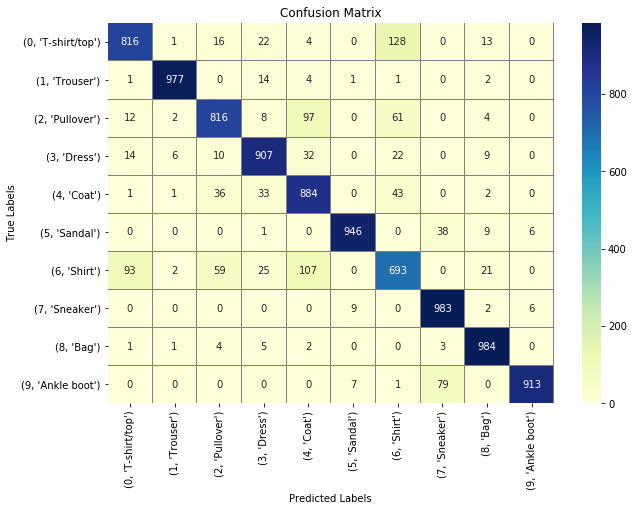

In [15]:
conf_matrix = metrics.confusion_matrix(l,p)
print(conf_matrix)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in enumerate(class_name)],
                  columns = [i for i in enumerate(class_name)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu",linewidth=0.02,linecolor="gray")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

## 3. Deploy in real world. (15 marks)

Take 3 photos that belongs to the 10 classes (e.g. clothes, shoes) in your real life. Use either Python or other software (Photoshop, Gimp etc) to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28.

### 3.1 Load and visualise your own images (5 marks)

[array([[  2,   6,   7,   3,   0,   2,   4,   4,   1,   6,   6,   3,   4,
          7,   5,   0,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  1,   3,   4,   3,   2,   3,   3,   2,   4,   3,   0,   0,   0,
          0,   2,   5,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  2,   0,   1,   4,   5,   3,   2,   2,   1,   2,   7,  10,   9,
          4,   2,   4,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  4,   2,   2,   5,   5,   2,   2,   4,   3,   2,   1,   0,   0,
          2,   3,   4,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  5,   4,   3,   3,   1,   0,   2,   5,   1,   4,   4,   1,   3,
          7,   5,   0,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [  3,   4,   4,   1,   0,   2,   3,   2,   5,   6,   6,   4,   5,
          7,   5,   2,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3],
       [ 

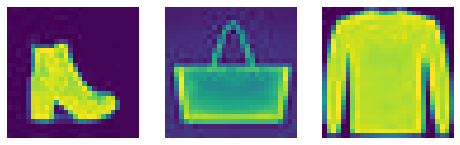

In [101]:
# ankle_boot = rgb2gray(image.imread('rsz_ankle_boots.jpg'))
# bag = rgb2gray(image.imread('rsz_bag.jpg'))
# pullover = rgb2gray(image.imread('rsz_pullover.jpg'))
own_images = []
fig = plt.figure(figsize=(8,8))
# own_images.append(ankle_boot)
# own_images.append(bag)
# own_images.append(pullover)
columns=3
rows = 1

ankle_boot = cv2.imread('rsz_ankle_boots.jpg',0)
bag = cv2.imread('rsz_bag.jpg',0)
pullover = cv2.imread('rsz_pullover.jpg',0)
# own_images.append(ankle_boot)
# own_images.append(bag)
# own_images.append(pullover)




# ankle_boot = Image.open('rsz_ankle_boots.jpg').convert('LA')
# bag = Image.open('rsz_bag.jpg').convert('LA')
# pullover = Image.open('rsz_pullover.jpg').convert('LA')
own_images.append(ankle_boot)
own_images.append(bag)
own_images.append(pullover)
print(own_images)

for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(own_images[i-1])
plt.show()


### 3.2 Test your network on the real images and display the classification results. (5 marks)

In [104]:
# model.eval()
# expand_image = np.expand_dims(np.array(own_images),axis=0)
# expand_image = np.expand_dims(expand_image,axis=0)
# image_tensor = torch.from_numpy(expand_image)
# print(image_tensor.shape)
# image_arr = []
# for i in range(3):
#   image_arr=np.array(np.array(own_images[i]))
# print(image_arr)

# expand_image = np.expand_dims(np.array(image_arr),axis=0)
# image_tensor = torch.from_numpy(expand_image)
# print(tensor_image.shape)

x = np.array(own_images)
x.shape
model.eval()
with torch.no_grad():
  for inputs in image_tensor:
    inputs = inputs.to(device)
    print(inputs.shape)
    outputs = model(inputs)


torch.Size([1, 1, 28, 28])


RuntimeError: ignored

### 3.3 Discuss the classification results. (5 marks)

Does the model work? Is there anyway to improve the real life performance of the model?